In [1]:
!pip install openpyxl scipy

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, Rbf
import matplotlib.colors as mcolors
from google.colab import files

In [14]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def cargar_excel():
    """
    Carga el archivo Excel y muestra información de las hojas
    """
    print("Por favor, sube tu archivo Excel (laboratorio3.xlsx)")
    uploaded = files.upload()

    filename = list(uploaded.keys())[0]
    print(f"Archivo subido: {filename}")

    # Leer todas las hojas disponibles
    xl_file = pd.ExcelFile(filename)
    hojas_disponibles = xl_file.sheet_names
    print(f"Hojas disponibles: {hojas_disponibles}")

    return filename, hojas_disponibles

In [15]:
def extraer_datos_hoja(filename, nombre_hoja):
    """
    Extrae datos de líneas equipotenciales de una hoja específica
    """
    try:
        df = pd.read_excel(filename, sheet_name=nombre_hoja, header=None)
        print(f"\n=== Procesando hoja: {nombre_hoja} ===")
        print(f"Dimensiones: {df.shape}")

        # Buscar la fila que contiene 'Voltaje'
        fila_voltaje = None
        for i in range(min(20, len(df))):  # Buscar en las primeras 20 filas
            if df.iloc[i, 2] == 'Voltaje':
                fila_voltaje = i
                break

        if fila_voltaje is None:
            print(f"No se encontraron datos de voltaje en {nombre_hoja}")
            return None, None, None

        # Extraer voltajes
        voltajes = []
        for j in range(3, 13):
            if j < df.shape[1]:
                valor = df.iloc[fila_voltaje, j]
                if pd.notna(valor):
                    voltaje_str = str(valor).replace('V', '').replace('v', '').strip()
                    try:
                        voltaje_num = float(voltaje_str)
                        voltajes.append(voltaje_num)
                    except:
                        voltajes.append(voltaje_str)

        print(f"Voltajes encontrados: {voltajes}")

        # Extraer todas las coordenadas
        todas_coordenadas = []
        voltajes_array = []

        for idx, voltaje in enumerate(voltajes):
            columna = 3 + idx
            if columna >= df.shape[1]:
                continue

            for fila in range(fila_voltaje + 1, min(fila_voltaje + 11, len(df))):
                if pd.notna(df.iloc[fila, columna]):
                    coord_str = str(df.iloc[fila, columna])

                    # Procesar coordenadas
                    try:
                        coord_str = coord_str.replace('(', '').replace(')', '').replace(' ', '')

                        if ',' in coord_str:
                            partes = coord_str.split(',')
                            if len(partes) == 2:
                                x, y = map(float, partes)
                                todas_coordenadas.append((x, y))
                                voltajes_array.append(float(voltaje) if isinstance(voltaje, str) else voltaje)
                            elif len(partes) == 3:
                                # Manejar formato (-2,-7,1)
                                x = float(partes[0])
                                y = float(partes[1] + '.' + partes[2])
                                todas_coordenadas.append((x, y))
                                voltajes_array.append(float(voltaje) if isinstance(voltaje, str) else voltaje)
                    except Exception as e:
                        print(f"Error procesando coordenada '{coord_str}': {e}")
                        continue

        if not todas_coordenadas:
            print(f"No se encontraron coordenadas válidas en {nombre_hoja}")
            return None, None, None

        print(f"Total de puntos: {len(todas_coordenadas)}")
        return np.array(todas_coordenadas), np.array(voltajes_array), voltajes

    except Exception as e:
        print(f"Error procesando hoja {nombre_hoja}: {e}")
        return None, None, None

In [16]:
def calcular_gradiente(X, Y, Z):
    """
    Calcula el gradiente del campo eléctrico (dirección del campo)
    """
    # Calcular gradientes en ambas direcciones
    dZ_dx, dZ_dy = np.gradient(Z)

    # El campo eléctrico es E = -∇V, pero para visualización usamos la dirección
    # Las flechas apuntan en la dirección de mayor potencial a menor potencial
    magnitud = np.sqrt(dZ_dx**2 + dZ_dy**2)

    # Normalizar para evitar flechas muy largas
    mask = magnitud > 0
    dZ_dx[mask] = dZ_dx[mask] / magnitud[mask]
    dZ_dy[mask] = dZ_dy[mask] / magnitud[mask]

    return -dZ_dx, -dZ_dy  # Negativo porque campo va de mayor a menor potencial

In [17]:
def crear_mapa_calor_con_flechas(coordenadas, voltajes, nombre_hoja, voltajes_unicos):
    """
    Crea un mapa de calor mejorado con interpolación de líneas equipotenciales
    y flechas que muestran la dirección del campo eléctrico
    """
    if coordenadas is None or len(coordenadas) == 0:
        print(f"No hay datos para graficar en {nombre_hoja}")
        return

    # Crear grid para interpolación
    x_min, x_max = coordenadas[:, 0].min(), coordenadas[:, 0].max()
    y_min, y_max = coordenadas[:, 1].min(), coordenadas[:, 1].max()

    # Extender un poco los límites
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * 0.1
    x_max += x_range * 0.1
    y_min -= y_range * 0.1
    y_max += y_range * 0.1

    # Crear grid más denso para mejor interpolación
    grid_x, grid_y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

    # Interpolar datos usando diferentes métodos
    try:
        # Método 1: Interpolación lineal
        grid_z_linear = griddata(coordenadas, voltajes, (grid_x, grid_y), method='linear', fill_value=np.nan)

        # Método 2: Interpolación cúbica
        grid_z_cubic = griddata(coordenadas, voltajes, (grid_x, grid_y), method='cubic', fill_value=np.nan)

        # Usar interpolación lineal como fallback si cúbica falla
        if np.isnan(grid_z_cubic).all():
            grid_z_cubic = grid_z_linear.copy()

    except Exception as e:
        print(f"Error en interpolación: {e}")
        # Fallback a interpolación simple
        grid_z_linear = griddata(coordenadas, voltajes, (grid_x, grid_y), method='nearest', fill_value=np.nan)
        grid_z_cubic = grid_z_linear.copy()

    # Calcular gradientes para las flechas
    try:
        Ex_linear, Ey_linear = calcular_gradiente(grid_x, grid_y, grid_z_linear)
        Ex_cubic, Ey_cubic = calcular_gradiente(grid_x, grid_y, grid_z_cubic)
    except Exception as e:
        print(f"Error calculando gradiente: {e}")
        Ex_linear, Ey_linear = None, None
        Ex_cubic, Ey_cubic = None, None

    # Crear figura con 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Contornos mejorados
    if len(voltajes_unicos) > 3:
        niveles = np.linspace(min(voltajes_unicos), max(voltajes_unicos), 15)
    else:
        niveles = voltajes_unicos

    # ===== SUBPLOT 1: Mapa de calor con contornos y flechas =====
    im = ax1.imshow(grid_z_linear.T, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='plasma', alpha=0.7, aspect='auto')

    # Contornos principales
    contour = ax1.contour(grid_x, grid_y, grid_z_linear, levels=niveles,
                         colors='white', linewidths=1.5, alpha=0.8)
    ax1.clabel(contour, inline=True, fontsize=8, fmt='%.1fV')

    # Añadir flechas del campo eléctrico (cada 10 puntos para evitar saturación)
    if Ex_linear is not None and Ey_linear is not None:
        skip = 10
        ax1.quiver(grid_x[::skip, ::skip], grid_y[::skip, ::skip],
                  Ex_linear[::skip, ::skip], Ey_linear[::skip, ::skip],
                  scale=30, color='red', alpha=0.7, width=0.005)

    # Puntos originales
    scatter1 = ax1.scatter(coordenadas[:, 0], coordenadas[:, 1], c=voltajes,
                          cmap='plasma', edgecolors='black', s=60, alpha=0.9)

    ax1.set_xlabel('Coordenada X (cm)')
    ax1.set_ylabel('Coordenada Y (cm)')
    ax1.set_title(f'Mapa de Calor - {nombre_hoja}\nLíneas Equipotenciales + Campo Eléctrico')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')

    # Barra de color
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Voltaje (V)')

    # ===== SUBPLOT 2: Interpolación cúbica suavizada con flechas =====
    im2 = ax2.imshow(grid_z_cubic.T, extent=[x_min, x_max, y_min, y_max],
                    origin='lower', cmap='viridis', alpha=0.7, aspect='auto')

    # Contornos de interpolación cúbica
    contour2 = ax2.contour(grid_x, grid_y, grid_z_cubic, levels=niveles,
                          colors='white', linewidths=2, alpha=0.9)
    ax2.clabel(contour2, inline=True, fontsize=8, fmt='%.1fV')

    # Contornos rellenos
    contourf = ax2.contourf(grid_x, grid_y, grid_z_cubic, levels=niveles,
                           alpha=0.5, cmap='viridis')

    # Añadir flechas del campo eléctrico
    if Ex_cubic is not None and Ey_cubic is not None:
        skip = 10
        ax2.quiver(grid_x[::skip, ::skip], grid_y[::skip, ::skip],
                  Ex_cubic[::skip, ::skip], Ey_cubic[::skip, ::skip],
                  scale=30, color='yellow', alpha=0.8, width=0.005)

    ax2.scatter(coordenadas[:, 0], coordenadas[:, 1], c=voltajes,
               cmap='viridis', edgecolors='black', s=50, alpha=0.8)

    ax2.set_xlabel('Coordenada X (cm)')
    ax2.set_ylabel('Coordenada Y (cm)')
    ax2.set_title(f'Interpolación Cúbica - {nombre_hoja}\nLíneas + Dirección Campo Eléctrico')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')

    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Voltaje (V)')

    # ===== SUBPLOT 3: Solo campo eléctrico (visualización clara) =====
    # Contornos suaves
    contour3 = ax3.contour(grid_x, grid_y, grid_z_cubic, levels=niveles,
                          colors='gray', linewidths=1, alpha=0.6, linestyles='--')
    ax3.clabel(contour3, inline=True, fontsize=8, fmt='%.1fV')

    # Campo eléctrico más denso
    if Ex_cubic is not None and Ey_cubic is not None:
        skip = 6  # Más flechas para mejor visualización
        ax3.quiver(grid_x[::skip, ::skip], grid_y[::skip, ::skip],
                  Ex_cubic[::skip, ::skip], Ey_cubic[::skip, ::skip],
                  scale=25, color='blue', alpha=0.8, width=0.006,
                  headwidth=3, headlength=4)

    # Puntos originales
    ax3.scatter(coordenadas[:, 0], coordenadas[:, 1], c='red', s=40, alpha=0.7)

    ax3.set_xlabel('Coordenada X (cm)')
    ax3.set_ylabel('Coordenada Y (cm)')
    ax3.set_title(f'Campo Eléctrico - {nombre_hoja}\nFlechas: Dirección del Campo')
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')

    # Añadir leyenda para las flechas
    ax3.quiver([x_min + 0.1*x_range], [y_min + 0.1*y_range],
              [1], [0], scale=25, color='blue', width=0.006,
              label='Dirección campo eléctrico')
    ax3.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # ===== GRÁFICO ADICIONAL: Interpolación detallada con campo eléctrico =====
    fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(20, 8))

    # Interpolación detallada para visualización suave
    xi = np.linspace(x_min, x_max, 300)
    yi = np.linspace(y_min, y_max, 300)
    XI, YI = np.meshgrid(xi, yi)

    try:
        # Usar RBF para interpolación más suave
        rbf = Rbf(coordenadas[:, 0], coordenadas[:, 1], voltajes, function='linear')
        ZI = rbf(XI, YI)

        # Calcular gradiente para RBF
        dZI_dx, dZI_dy = np.gradient(ZI)
        magnitud_rbf = np.sqrt(dZI_dx**2 + dZI_dy**2)
        mask_rbf = magnitud_rbf > 0
        dZI_dx[mask_rbf] = dZI_dx[mask_rbf] / magnitud_rbf[mask_rbf]
        dZI_dy[mask_rbf] = dZI_dy[mask_rbf] / magnitud_rbf[mask_rbf]
        Ex_rbf, Ey_rbf = -dZI_dx, -dZI_dy

        # SUBPLOT 4: Interpolación RBF con campo
        contourf_det = ax4.contourf(XI, YI, ZI, levels=50, alpha=0.7, cmap='plasma')
        contour_det = ax4.contour(XI, YI, ZI, levels=niveles, colors='black', linewidths=1.5)
        ax4.clabel(contour_det, inline=True, fontsize=9, fmt='%.1fV')

        # Flechas del campo eléctrico
        skip_rbf = 12
        ax4.quiver(XI[::skip_rbf, ::skip_rbf], YI[::skip_rbf, ::skip_rbf],
                  Ex_rbf[::skip_rbf, ::skip_rbf], Ey_rbf[::skip_rbf, ::skip_rbf],
                  scale=40, color='white', alpha=0.8, width=0.004)

    except Exception as e:
        print(f"Error en interpolación RBF: {e}")
        # Fallback a griddata
        ZI = griddata(coordenadas, voltajes, (XI, YI), method='cubic', fill_value=np.nan)
        contourf_det = ax4.contourf(XI, YI, ZI, levels=50, alpha=0.7, cmap='plasma')
        contour_det = ax4.contour(XI, YI, ZI, levels=niveles, colors='black', linewidths=1.5)
        ax4.clabel(contour_det, inline=True, fontsize=9, fmt='%.1fV')

    # Puntos originales
    scatter_det = ax4.scatter(coordenadas[:, 0], coordenadas[:, 1], c=voltajes,
                            cmap='plasma', edgecolors='white', s=80, alpha=1.0)

    ax4.set_xlabel('Coordenada X (cm)')
    ax4.set_ylabel('Coordenada Y (cm)')
    ax4.set_title(f'Interpolación RBF - {nombre_hoja}\nCampo Eléctrico Equipotencial')
    ax4.grid(True, alpha=0.3)
    ax4.set_aspect('equal')

    cbar_det = plt.colorbar(contourf_det, ax=ax4)
    cbar_det.set_label('Voltaje (V)')

    # SUBPLOT 5: Visualización física del campo eléctrico
    # Líneas de campo eléctrico (perpendiculares a equipotenciales)
    ax5.streamplot(XI, YI, Ex_rbf, Ey_rbf, color='blue', linewidth=1,
                  density=2, arrowsize=1.5, arrowstyle='->')

    # Líneas equipotenciales
    contour_phys = ax5.contour(XI, YI, ZI, levels=niveles, colors='red',
                              linewidths=1.5, alpha=0.7, linestyles='-')
    ax5.clabel(contour_phys, inline=True, fontsize=8, fmt='%.1fV')

    ax5.scatter(coordenadas[:, 0], coordenadas[:, 1], c='black', s=30, alpha=0.8)

    ax5.set_xlabel('Coordenada X (cm)')
    ax5.set_ylabel('Coordenada Y (cm)')
    ax5.set_title(f'Visualización Física - {nombre_hoja}\nRojo: Equipotenciales, Azul: Líneas Campo')
    ax5.grid(True, alpha=0.3)
    ax5.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # Información adicional
    print(f"\nEstadísticas para {nombre_hoja}:")
    print(f"- Rango de voltajes: {min(voltajes):.1f}V - {max(voltajes):.1f}V")
    print(f"- Número de puntos únicos: {len(np.unique(voltajes))}")
    print(f"- Área cubierta: X({x_min:.1f} a {x_max:.1f}), Y({y_min:.1f} a {y_max:.1f})")
    print(f"- Métodos de interpolación: Lineal, Cúbica y RBF")
    print(f"- Flechas muestran dirección del campo eléctrico (⊥ a equipotenciales)")

In [18]:
def procesar_todas_hojas(filename, hojas_disponibles):
    """
    Procesa todas las hojas del archivo Excel
    """
    resultados = {}

    for hoja in hojas_disponibles:
        if hoja.lower() != 'hoja1':  # Ignorar hojas vacías o por defecto
            coordenadas, voltajes, voltajes_unicos = extraer_datos_hoja(filename, hoja)

            if coordenadas is not None and voltajes is not None:
                resultados[hoja] = {
                    'coordenadas': coordenadas,
                    'voltajes': voltajes,
                    'voltajes_unicos': voltajes_unicos
                }

                # Crear gráficos mejorados para esta hoja
                crear_mapa_calor_con_flechas(coordenadas, voltajes, hoja, voltajes_unicos)
            else:
                print(f"\n--- No se pudieron procesar datos de {hoja} ---")

    return resultados

=== MAPAS DE CALOR MEJORADOS - LÍNEAS EQUIPOTENCIALES Y CAMPO ELÉCTRICO ===

Por favor, sube tu archivo Excel (laboratorio3.xlsx)


Saving laboratorio3 (3).xlsx to laboratorio3 (3) (2).xlsx
Archivo subido: laboratorio3 (3) (2).xlsx
Hojas disponibles: ['Barras paralelas', 'Anillo y barra']

=== Procesando hoja: Barras paralelas ===
Dimensiones: (13, 15)
Voltajes encontrados: [1.9, 2.1, 3.0, 3.7, 4.1, 5.7, 6.3, 6.9, 7.4, 8.2]
Error procesando coordenada '-7-,6': could not convert string to float: '-7-'
Total de puntos: 98


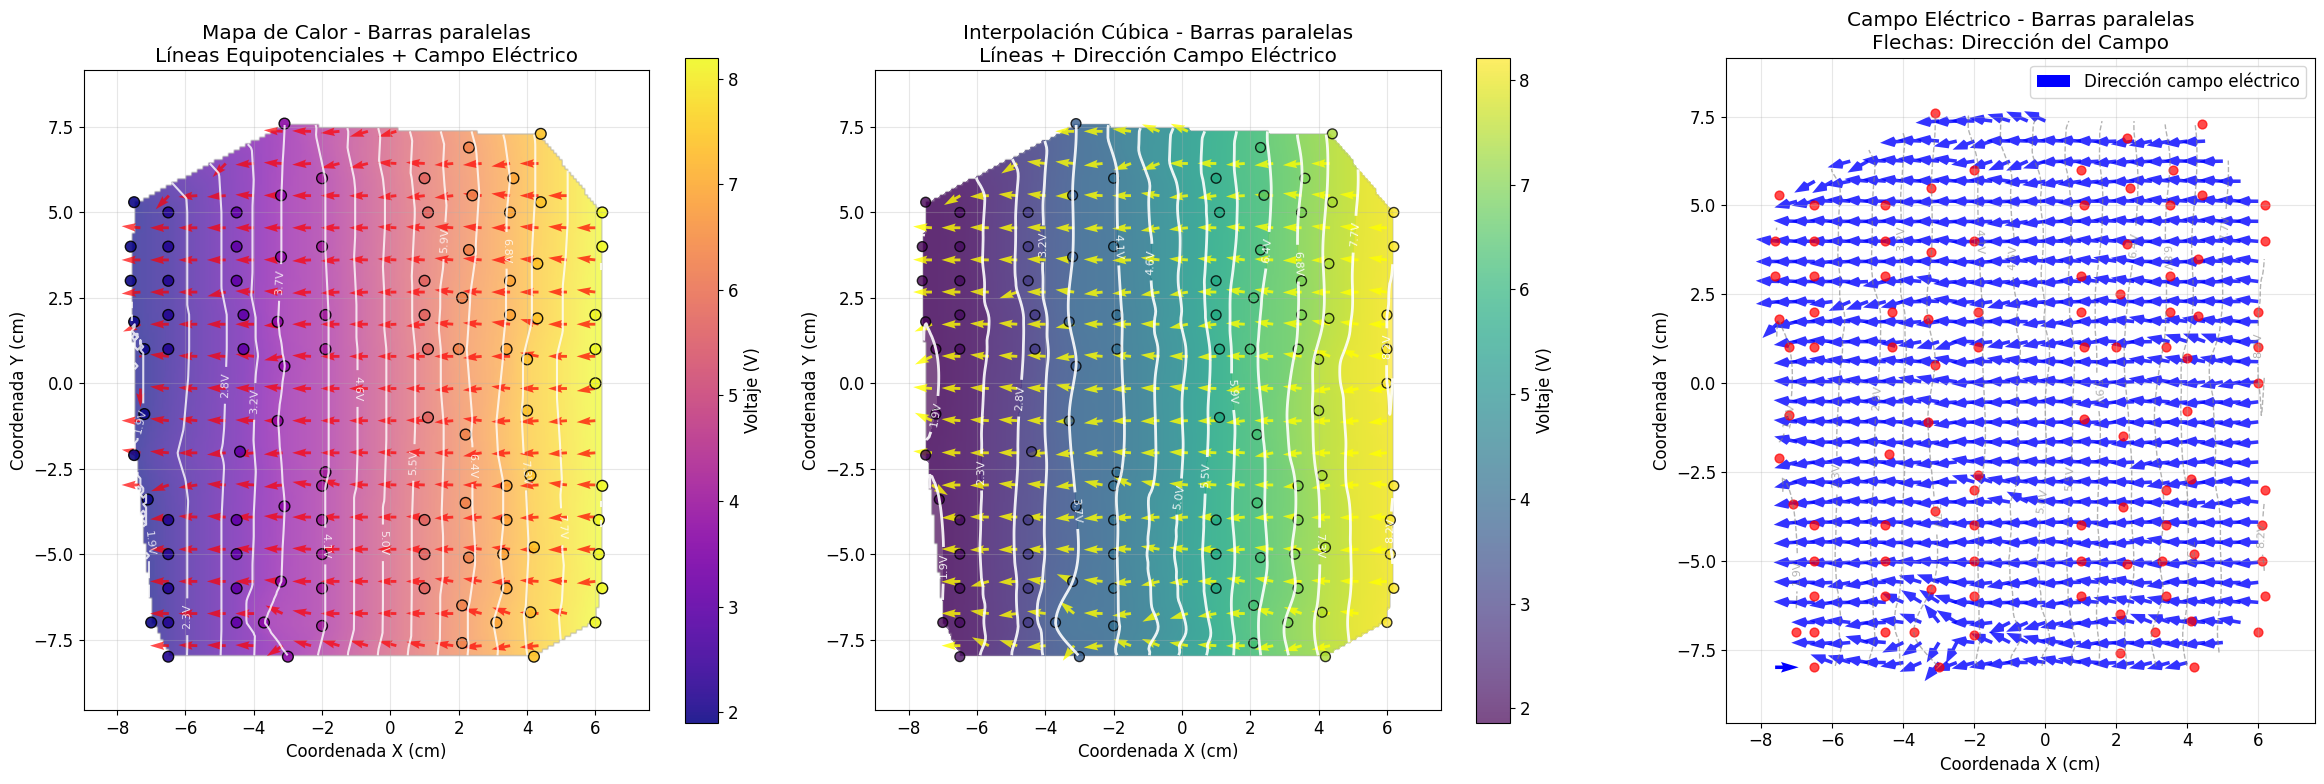

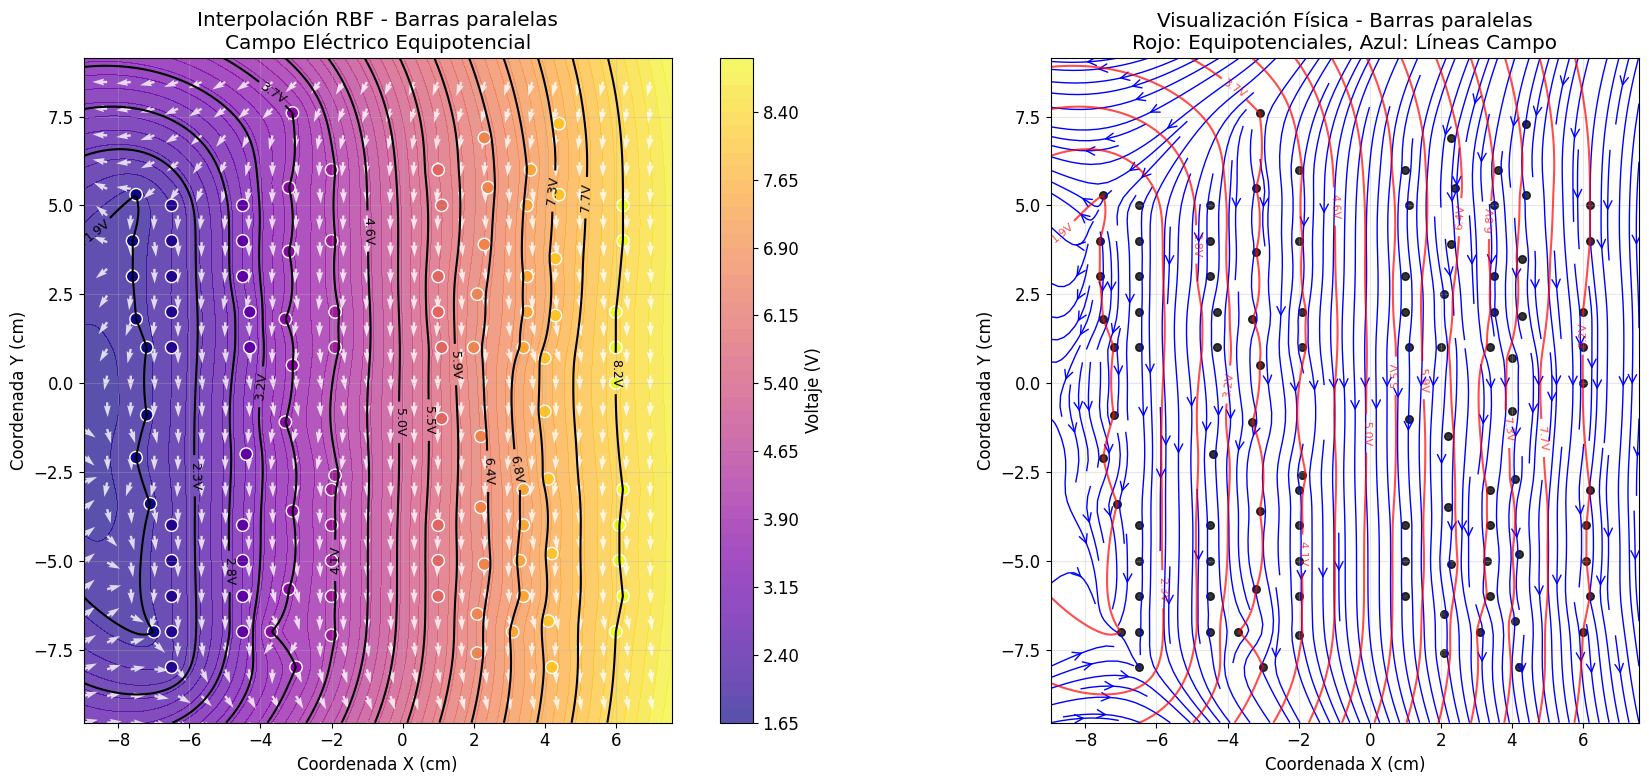


Estadísticas para Barras paralelas:
- Rango de voltajes: 1.9V - 8.2V
- Número de puntos únicos: 10
- Área cubierta: X(-9.0 a 7.6), Y(-9.6 a 9.2)
- Métodos de interpolación: Lineal, Cúbica y RBF
- Flechas muestran dirección del campo eléctrico (⊥ a equipotenciales)

=== Procesando hoja: Anillo y barra ===
Dimensiones: (13, 14)
Voltajes encontrados: [17.0, 2.1, 15.8, 17.6, 16.6, 17.8, 15.2, 12.5]
Total de puntos: 78


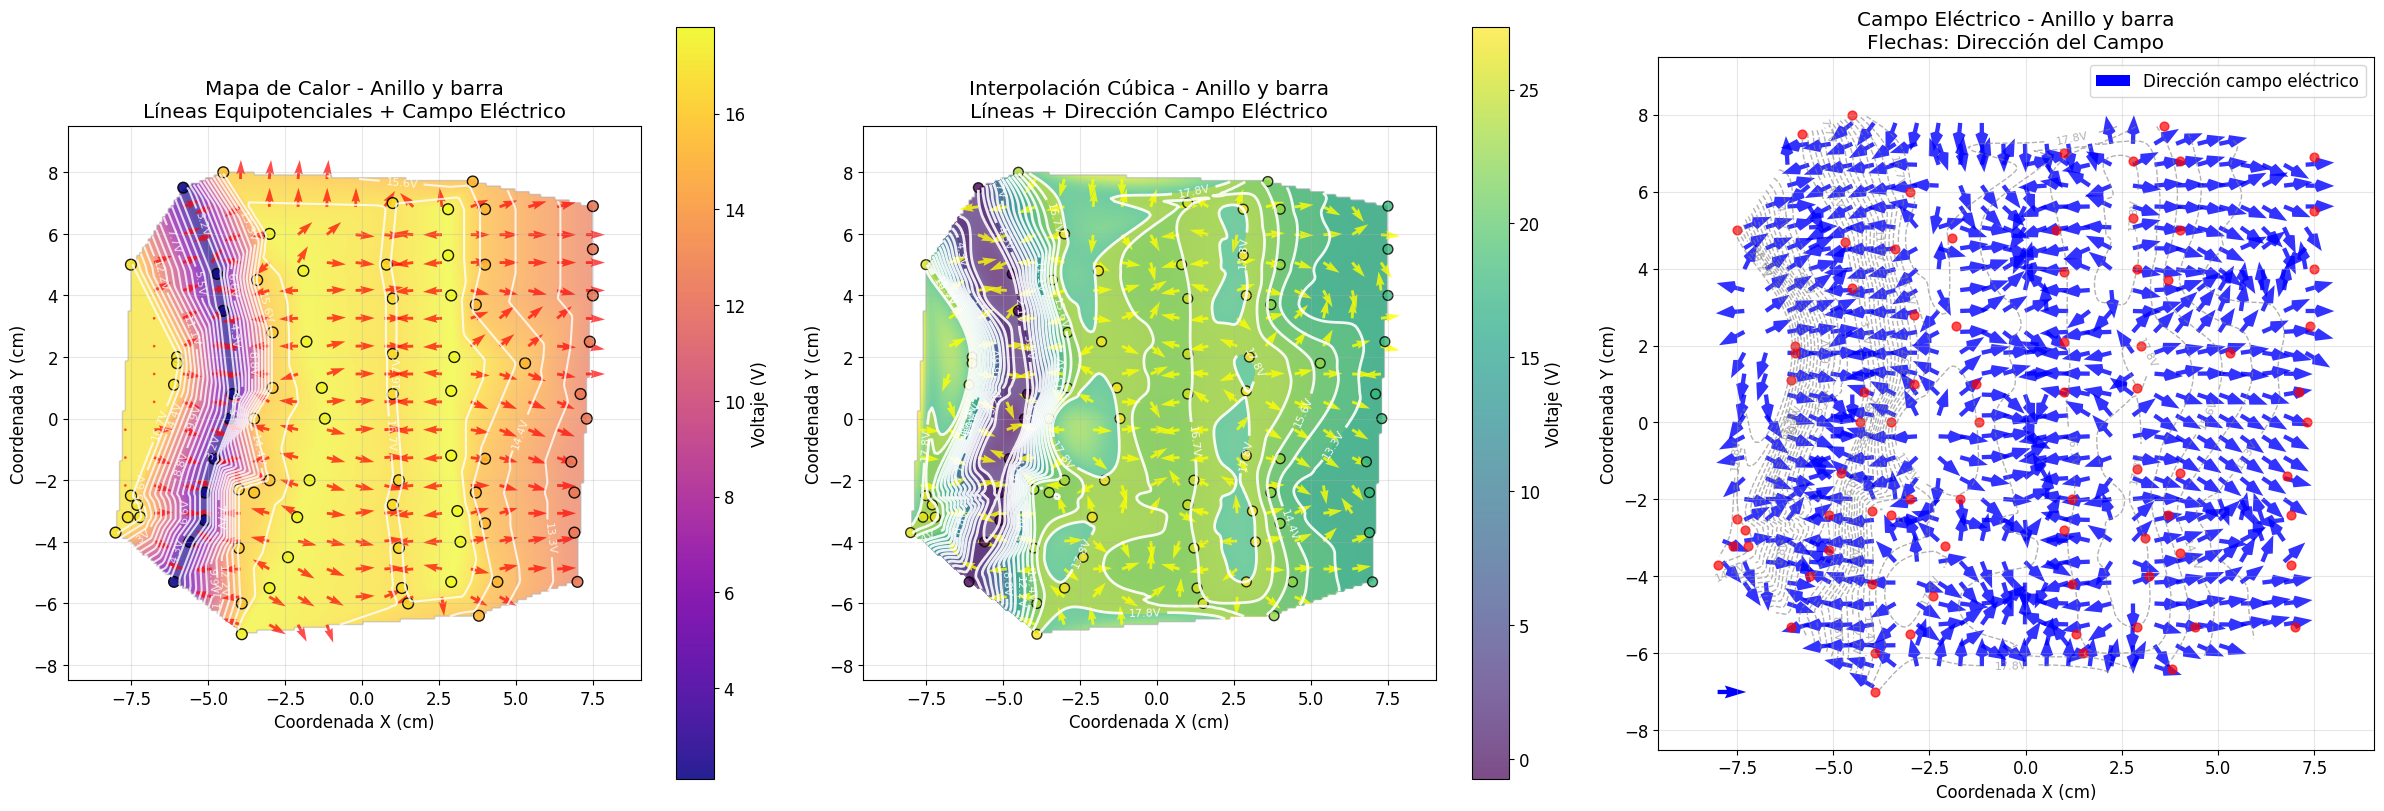

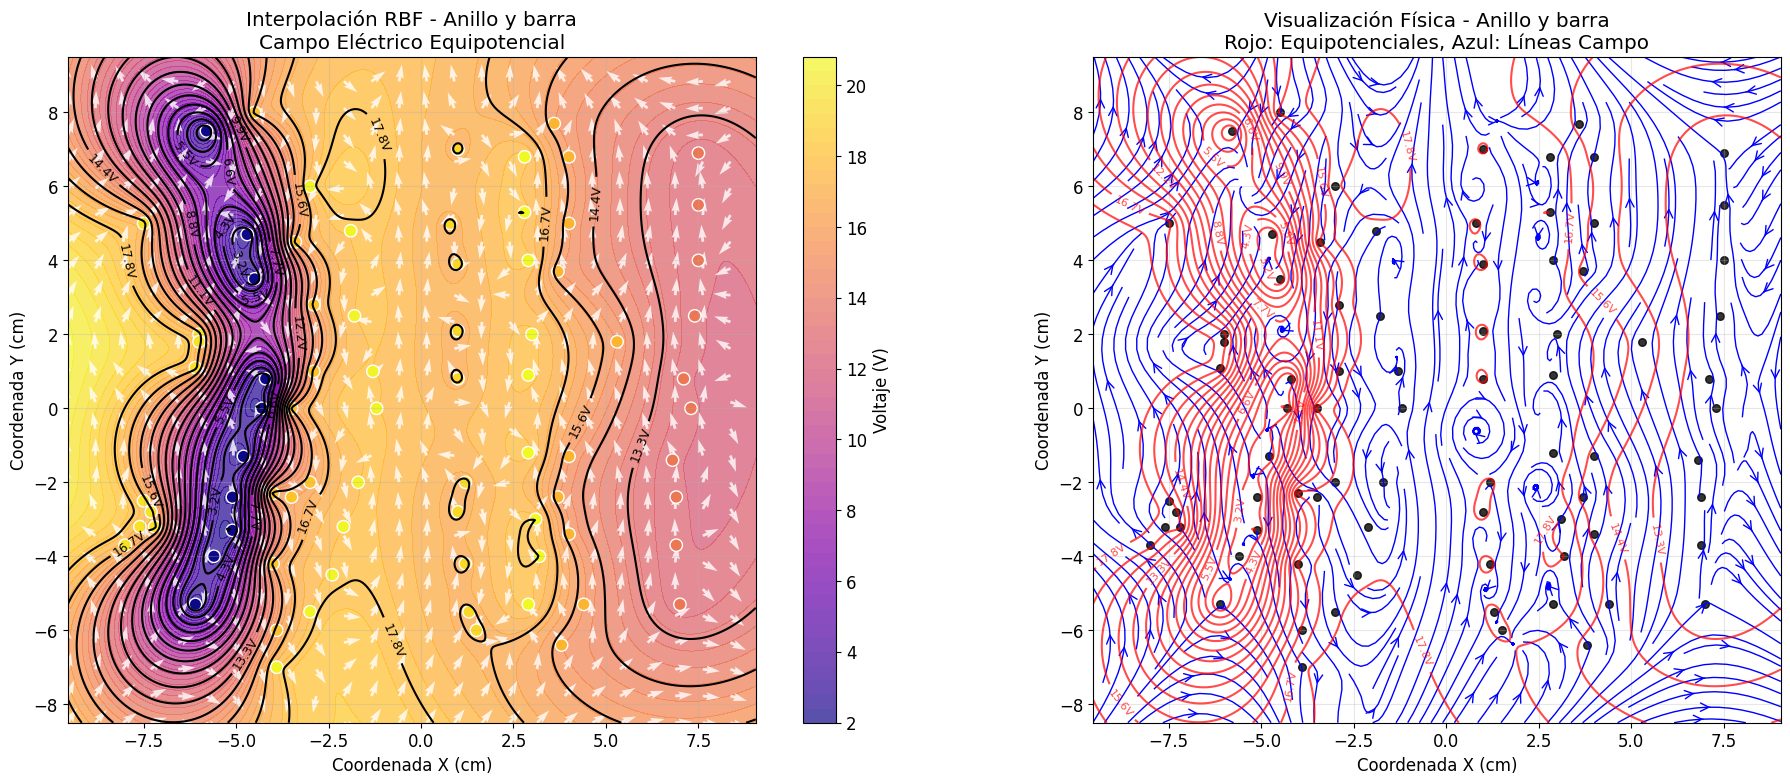


Estadísticas para Anillo y barra:
- Rango de voltajes: 2.1V - 17.8V
- Número de puntos únicos: 8
- Área cubierta: X(-9.6 a 9.1), Y(-8.5 a 9.5)
- Métodos de interpolación: Lineal, Cúbica y RBF
- Flechas muestran dirección del campo eléctrico (⊥ a equipotenciales)

RESUMEN FINAL
Barras paralelas: 98 puntos, 10 voltajes únicos
Anillo y barra: 78 puntos, 8 voltajes únicos

Total de hojas procesadas: 2
¡Proceso completado!


In [19]:
def main():
    """
    Función principal
    """
    print("=== MAPAS DE CALOR MEJORADOS - LÍNEAS EQUIPOTENCIALES Y CAMPO ELÉCTRICO ===\n")

    # Cargar archivo
    filename, hojas_disponibles = cargar_excel()

    # Procesar todas las hojas
    resultados = procesar_todas_hojas(filename, hojas_disponibles)

    # Resumen final
    print("\n" + "="*50)
    print("RESUMEN FINAL")
    print("="*50)

    for hoja, datos in resultados.items():
        if datos is not None:
            print(f"{hoja}: {len(datos['coordenadas'])} puntos, {len(datos['voltajes_unicos'])} voltajes únicos")

    print(f"\nTotal de hojas procesadas: {len(resultados)}")
    print("¡Proceso completado!")

if __name__ == "__main__":
    main()